In [1]:
import numpy as np 
import pandas as pd
import math as math
import random
import time

from keras.layers import Input, Dense
from keras.models import Model

import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from triplet_encoding import *
from shared_module import *

Using TensorFlow backend.


# Hyperparameters
- N_ANCHORS determines the number of anchors we find for each breed
- ENCODING_STRATEGY dictates the image encoding model and the size of the input vector

In [2]:
N_ANCHORS = ANCHORS_10
ENCODING_STRATEGY = VGG19_4096
ENCODING_SIZE = 4096
INPUT_FILE_PATH = './input/labels_train_small'

random.seed()


## Some interesting information about the dataset that we're working with

In [3]:
def sample_by_breed(df_train):
    breeds = df_train['breed'].unique()
    random.seed()
    breed = breeds[random.randint(0, len(breeds) - 1)]
    df_breed = df_train.loc[(df_train['breed'] == breed)]
    random_index = random.randint(0, (df_breed.shape[0] - 1))
    print(breed)
    show_img(df_breed.iloc[random_index].id)


def show_img(image_id):
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=image_id))
    plt.imshow(img)
    plt.show()
    

training_file_path = get_path(INPUT_FILE_PATH, N_ANCHORS, ENCODING_STRATEGY)

df_train = pd.read_csv(training_file_path('anchor'))

### Statistics about the breeds in dataset

In [4]:
print(df_train.groupby(['breed']).agg(['count']))

                               id encoding   anp cluster
                            count    count count   count
breed                                                   
basset                         65       65    65      65
bluetick                       68       68    68      68
collie                         69       69    69      69
german_short-haired_pointer    60       60    60      60
labrador_retriever             67       67    67      67
weimaraner                     68       68    68      68


### Breeds and sample of pictures

total number of breeds 6
bluetick


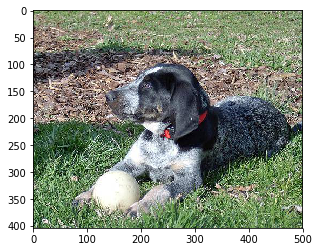

labrador_retriever


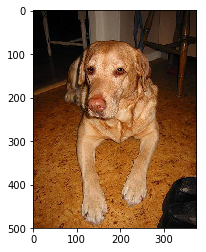

In [5]:
breeds = df_train['breed'].unique()

print('total number of breeds ' + str(len(breeds)))

sample_by_breed(df_train)
sample_by_breed(df_train)

In [6]:
def shuffle_triplets(df_triplets):
    return df_triplets.sample(frac=1).reset_index(drop=True)

df_triplets = pd.read_csv(training_file_path('triplets'))

## shuffle the triplets so that we don't just train all of a single breed first 

In [7]:
df_triplets = shuffle_triplets(df_triplets)
print('Total number of triplets ' + str(df_triplets.shape[0]))

Total number of triplets 19850


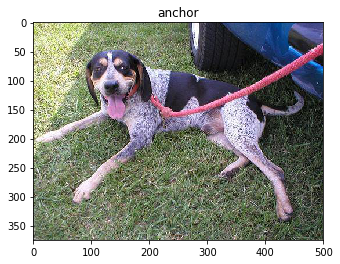

./input/train-2/dad425aa6e2d08d0743e6ffc4bfc407b.jpg
bluetick


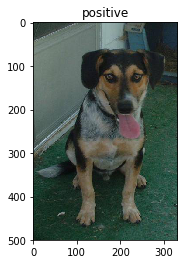

./input/train-2/d327e8ca5085a224a03dfcf4a6e984d7.jpg
bluetick


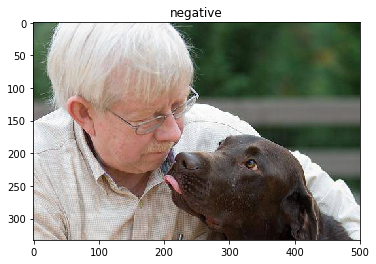

./input/train-2/61657cb3669e35e9c6f4f56b4e50bb6f.jpg
labrador_retriever


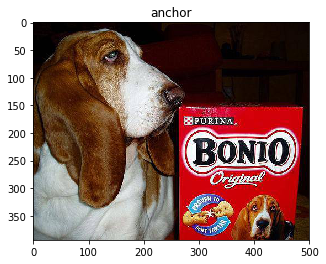

./input/train-2/819f97c27a2f46f36a88d1e1cecd8e0a.jpg
basset


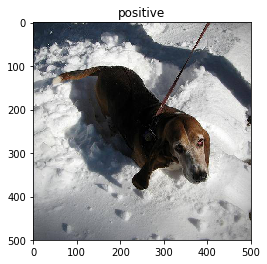

./input/train-2/4f031cd233512f9c4c3bbfe354510eac.jpg
basset


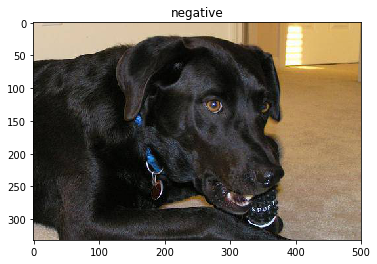

./input/train-2/212f7cfa5a153997c4a1ee64dcfbf76f.jpg
labrador_retriever


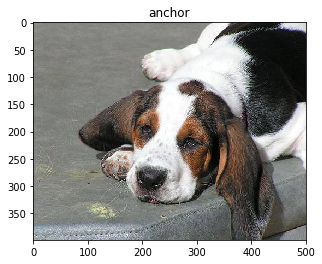

./input/train-2/54656e8a4fcc7c6d6c36579a8135231e.jpg
basset


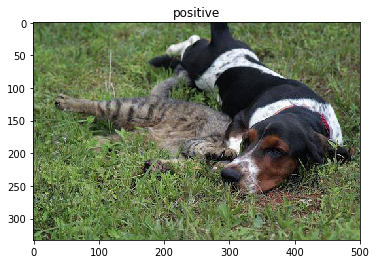

./input/train-2/5f49abbd269cee0dffc6bcde1daa6bd3.jpg
basset


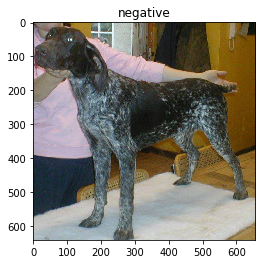

./input/train-2/5d0804abeb6f079d8e4e8fc8d9891f08.jpg
german_short-haired_pointer


In [8]:
def show_triplets(df_triplets):
    row = df_triplets.iloc[random.randint(0, df_triplets.shape[0]-1)]
    anchor_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['anchor_id'])
    img = Image.open(anchor_path)
    plt.imshow(img)
    plt.title('anchor')
    plt.show()
    print(anchor_path)
    print(row['anchor_type'])
    positive_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['positive_id'])
    img = Image.open(positive_path)
    plt.imshow(img)
    plt.title('positive')
    plt.show()
    print(positive_path)
    print(row['positive_type'])
    negative_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['negative_id'])
    img = Image.open(negative_path)
    plt.imshow(img)
    plt.title('negative')
    plt.show()
    print(negative_path)
    print(row['negative_type'])

show_triplets(df_triplets)
show_triplets(df_triplets)
show_triplets(df_triplets)


### Load the encoding for the given triplets into memory

In [9]:
def load_triplets(df_triplets):
    n_triplets = df_triplets.shape[0]
    anchors = np.zeros((n_triplets, 1, ENCODING_SIZE))
    pos = np.zeros((n_triplets, 1, ENCODING_SIZE))
    negs = np.zeros((n_triplets, 1, ENCODING_SIZE))

    i = 0
    for i, triplet in df_triplets.iterrows():
        anchors[i] = np.loadtxt(triplet['anchor_encoding'])
        pos[i] = np.loadtxt(triplet['positive_encoding'])
        negs[i] = np.loadtxt(triplet['negative_encoding'])
        i = i + 1
        if (i % 1000 == 0):
            print('Loaded ' + str(i) + ' triplets')
    print('Loaded ' + str(n_triplets))
    
    return anchors, pos, negs

anchors, pos, negs = load_triplets(df_triplets)


Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 4000 triplets
Loaded 5000 triplets
Loaded 6000 triplets
Loaded 7000 triplets
Loaded 8000 triplets
Loaded 9000 triplets
Loaded 10000 triplets
Loaded 11000 triplets
Loaded 12000 triplets
Loaded 13000 triplets
Loaded 14000 triplets
Loaded 15000 triplets
Loaded 16000 triplets
Loaded 17000 triplets
Loaded 18000 triplets
Loaded 19000 triplets
Loaded 19850


In [10]:
encoding_model = input_encoding_model((1, ENCODING_SIZE))
training_model = input_training_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), encoding_model)
training_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
training_model.optimizer.lr = 0.00000001


because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies

In [11]:
n_triplets = df_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))


training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=3, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
print('total ' + str(total))
print('bad predictions ' + str(bad_predictions))
print('accuracy ' + str(accuracy))


df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
df_train_results_mismatch.head()

Epoch 1/1
19850/19850 [==============================] - 175s 9ms/step - loss: 0.1200 - inputEncodingModel_loss_1: 0.0400 - inputEncodingModel_loss_2: 0.0400 - inputEncodingModel_loss_3: 0.0400 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
total 397
bad predictions 79
accuracy 0.801007556675063


,id,breed,encoding,anp,cluster,predicted_breed,prediction,prediction_id,prediction_encoding
1,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,P,1,collie,False,5f1c875f82b501810e73814ece9180e1,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
17,2cb1a35c9a986633dcc2c7289bafb02e,basset,./input/vgg19_4096/2cb1a35c9a986633dcc2c7289ba...,P,1,german_short-haired_pointer,False,5532877c0fefc8ee8767134b81481c22,./input/vgg19_4096/5532877c0fefc8ee8767134b814...
19,37f606ad9055e319baa52d857a30dc89,basset,./input/vgg19_4096/37f606ad9055e319baa52d857a3...,P,2,bluetick,False,dad425aa6e2d08d0743e6ffc4bfc407b,./input/vgg19_4096/dad425aa6e2d08d0743e6ffc4bf...
26,46828dcd8f519d13b320c9ea06a93a47,basset,./input/vgg19_4096/46828dcd8f519d13b320c9ea06a...,P,1,labrador_retriever,False,42f43e8067b90430b6a05afe0b1ddbca,./input/vgg19_4096/42f43e8067b90430b6a05afe0b1...
38,6620cb2082fd57c0c56f2e4903b5339a,basset,./input/vgg19_4096/6620cb2082fd57c0c56f2e4903b...,P,7,labrador_retriever,False,817d2fafec8ab5c3205bb0c0ff53fcd7,./input/vgg19_4096/817d2fafec8ab5c3205bb0c0ff5...


In [12]:
def extract_triplets(df_mismatch, df_train):
    new_triplets_list = []

    for i, bad_pred in df_mismatch.iterrows():
        pred_anchors = df_train.loc[(df_train.breed == bad_pred.breed)]
        for i, pred_anchor in pred_anchors.iterrows():
            result = []
            result.append(pred_anchor['id'])
            result.append(pred_anchor['breed'])
            result.append(pred_anchor['encoding'])
            result.append(bad_pred['id'])
            result.append(bad_pred['breed'])
            result.append(bad_pred['encoding'])
            result.append(bad_pred['prediction_id'])
            result.append(bad_pred['predicted_breed'])
            result.append(bad_pred['prediction_encoding'])
            new_triplets_list.append(result)

    df_new_triplets = pd.DataFrame(new_triplets_list, columns=['anchor_id', 'anchor_type', 'anchor_encoding', 'positive_id', 'positive_type', 'positive_encoding', 'negative_id', 'negative_type', 'negative_encoding'])
    return df_new_triplets

df_new_triplets = extract_triplets(df_train_results_mismatch, df_train)
print(df_new_triplets.shape)
df_new_triplets.head()

(5251, 9)


,anchor_id,anchor_type,anchor_encoding,positive_id,positive_type,positive_encoding,negative_id,negative_type,negative_encoding
0,018aae5768833c34e3df30d63429251e,basset,./input/vgg19_4096/018aae5768833c34e3df30d6342...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
1,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
2,0653d31ae648e2a6628ee3f440729361,basset,./input/vgg19_4096/0653d31ae648e2a6628ee3f4407...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
3,07192213791150248bfb5bbe6b0b0373,basset,./input/vgg19_4096/07192213791150248bfb5bbe6b0...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
4,085faff5f472098801b371f077b2dc8b,basset,./input/vgg19_4096/085faff5f472098801b371f077b...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...


In [ ]:
anchors, pos, negs = load_triplets(df_new_triplets)
n_triplets = df_new_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))

training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=5, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
print('total ' + str(total))
print('bad predictions ' + str(bad_predictions))
print('accuracy ' + str(accuracy))

df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]

df_new_triplets = extract_triplets(df_train_results_mismatch, df_train)
df_new_triplets = shuffle_triplets(df_new_triplets)
df_new_triplets.head(5)

Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 4000 triplets
Loaded 5000 triplets
Loaded 5251
Epoch 1/1
5251/5251 [==============================] - 45s 9ms/step - loss: 0.1200 - inputEncodingModel_loss_1: 0.0400 - inputEncodingModel_loss_2: 0.0400 - inputEncodingModel_loss_3: 0.0400 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
total 397
bad predictions 79
accuracy 0.801007556675063


,anchor_id,anchor_type,anchor_encoding,positive_id,positive_type,positive_encoding,negative_id,negative_type,negative_encoding
0,018aae5768833c34e3df30d63429251e,basset,./input/vgg19_4096/018aae5768833c34e3df30d6342...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
1,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
2,0653d31ae648e2a6628ee3f440729361,basset,./input/vgg19_4096/0653d31ae648e2a6628ee3f4407...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
3,07192213791150248bfb5bbe6b0b0373,basset,./input/vgg19_4096/07192213791150248bfb5bbe6b0...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...
4,085faff5f472098801b371f077b2dc8b,basset,./input/vgg19_4096/085faff5f472098801b371f077b...,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,5f1c875f82b501810e73814ece9180e1,collie,./input/vgg19_4096/5f1c875f82b501810e73814ece9...


In [ ]:
anchors, pos, negs = load_triplets(df_new_triplets)
n_triplets = df_new_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))

training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=5, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
print('total ' + str(total))
print('bad predictions ' + str(bad_predictions))
print('accuracy ' + str(accuracy))

df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]

df_new_triplets = extract_triplets(df_train_results_mismatch, df_train)
df_new_triplets = shuffle_triplets(df_new_triplets)
df_new_triplets.head(5)


Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 4000 triplets
Loaded 5000 triplets
Loaded 5251
Epoch 1/5
4096/5251 [======================>.......] - ETA: 9s - loss: 0.1200 - inputEncodingModel_loss_1: 0.0400 - inputEncodingModel_loss_2: 0.0400 - inputEncodingModel_loss_3: 0.0400 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00 